https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

# DOG AND CAT 데이터 셋 다운로드

In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary

import PIL
import shutil
import zipfile
import glob
import os
import time

In [116]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_zip_dir = './dataset/dogs-vs-cats-redux-kernels-edition'
train_zip_dir = os.path.join(data_zip_dir, 'train.zip')
test_zip_dir = os.path.join(data_zip_dir, 'test.zip')

"""
압축 해제 

with zipfile.ZipFile(train_zip_dir, 'r') as z:
    z.extractall()
with zipfile.ZipFile(test_zip_dir, 'r') as z:
    z.extractall()
"""
train_dir = os.path.join(os.getcwd(), 'train')
test_dir = os.path.join(os.getcwd(), 'test')

 
train_set_dir = os.path.join(train_dir, 'train')
valid_set_dir = os.path.join(train_dir, 'valid')
test_set_dir = os.path.join(train_dir, 'test')

dog_files = [f'dog.{i}.jpg' for i in range(12500)]
cat_files = [f'cat.{i}.jpg' for i in range(12500)]

print('set folders')
"""
train / test 폴더 생성 

train_dir = os.path.join(os.getcwd(), 'train')
test_dir = os.path.join(os.getcwd(), 'test')
 
train_set_dir = os.path.join(train_dir, 'train')
os.mkdir(train_set_dir)
valid_set_dir = os.path.join(train_dir, 'valid')
os.mkdir(valid_set_dir)
test_set_dir = os.path.join(train_dir, 'test')
os.mkdir(test_set_dir)
 
dog_files = [f'dog.{i}.jpg' for i in range(12500)]
cat_files = [f'cat.{i}.jpg' for i in range(12500)]

for dog, cat in zip(dog_files[:10000], cat_files[:10000]):
    src = os.path.join(train_dir, dog)
    dst = os.path.join(train_set_dir, dog)
    shutil.move(src, dst)
    src = os.path.join(train_dir, cat)
    dst = os.path.join(train_set_dir, cat)
    shutil.move(src, dst)
    
for dog, cat in zip(dog_files[10000:11250], cat_files[10000:11250]):
    src = os.path.join(train_dir, dog)
    dst = os.path.join(valid_set_dir, dog)
    shutil.move(src, dst)
    src = os.path.join(train_dir, cat)
    dst = os.path.join(valid_set_dir, cat)
    shutil.move(src, dst)
    
for dog, cat in zip(dog_files[11250:12500], cat_files[11250:12500]):
    src = os.path.join(train_dir, dog)
    dst = os.path.join(test_set_dir, dog)
    shutil.move(src, dst)
    src = os.path.join(train_dir, cat)
    dst = os.path.join(test_set_dir, cat)
    shutil.move(src, dst)
"""

set folders


"\ntrain / test 폴더 생성 \n\ntrain_dir = os.path.join(os.getcwd(), 'train')\ntest_dir = os.path.join(os.getcwd(), 'test')\n \ntrain_set_dir = os.path.join(train_dir, 'train')\nos.mkdir(train_set_dir)\nvalid_set_dir = os.path.join(train_dir, 'valid')\nos.mkdir(valid_set_dir)\ntest_set_dir = os.path.join(train_dir, 'test')\nos.mkdir(test_set_dir)\n \ndog_files = [f'dog.{i}.jpg' for i in range(12500)]\ncat_files = [f'cat.{i}.jpg' for i in range(12500)]\n\nfor dog, cat in zip(dog_files[:10000], cat_files[:10000]):\n    src = os.path.join(train_dir, dog)\n    dst = os.path.join(train_set_dir, dog)\n    shutil.move(src, dst)\n    src = os.path.join(train_dir, cat)\n    dst = os.path.join(train_set_dir, cat)\n    shutil.move(src, dst)\n    \nfor dog, cat in zip(dog_files[10000:11250], cat_files[10000:11250]):\n    src = os.path.join(train_dir, dog)\n    dst = os.path.join(valid_set_dir, dog)\n    shutil.move(src, dst)\n    src = os.path.join(train_dir, cat)\n    dst = os.path.join(valid_set_dir,

In [117]:


print(f'the number of train set : {len(os.listdir(train_set_dir))}')
print(f'the number of validn set : {len(os.listdir(valid_set_dir))}')
print(f'the number of test set : {len(os.listdir(test_set_dir))}')

the number of train set : 20000
the number of validn set : 2500
the number of test set : 2500


데이터셋 Class 구현

In [118]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files, root, mode='train', transform=None):
        self.files = files
        self.root = root
        self.mode = mode
        self.transform=transform
        
        if 'cat' in files[0]:
            self.label = 0
        else:
            self.label = 1
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))
        
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            return img, np.array([self.label])
        else:
            return img, self.files[index]

In [119]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,244)),
    torchvision.transforms.ToTensor(),
])

train_dog_dataset = CustomDataset(dog_files[:10000], train_set_dir, transform=train_transform)
train_cat_dataset = CustomDataset(cat_files[:10000], train_set_dir, transform=train_transform)
valid_dog_dataset = CustomDataset(dog_files[10000:11250], valid_set_dir, transform=test_transform)
valid_cat_dataset = CustomDataset(cat_files[10000:11250], valid_set_dir, transform=test_transform)
test_dog_dataset = CustomDataset(dog_files[11250:], test_set_dir, transform=test_transform)
test_cat_dataset = CustomDataset(cat_files[11250:], test_set_dir, transform=test_transform)
 
train_dataset = torch.utils.data.ConcatDataset([train_dog_dataset, train_cat_dataset])
valid_dataset = torch.utils.data.ConcatDataset([valid_dog_dataset, valid_cat_dataset])
test_dataset = torch.utils.data.ConcatDataset([test_dog_dataset, test_cat_dataset])


print(f'number of train dataset : {len(train_dataset)}')
print(f'number of valid dataset : {len(valid_dataset)}')
print(f'number of test dataset : {len(test_dataset)}')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)


number of train dataset : 20000
number of valid dataset : 2500
number of test dataset : 2500


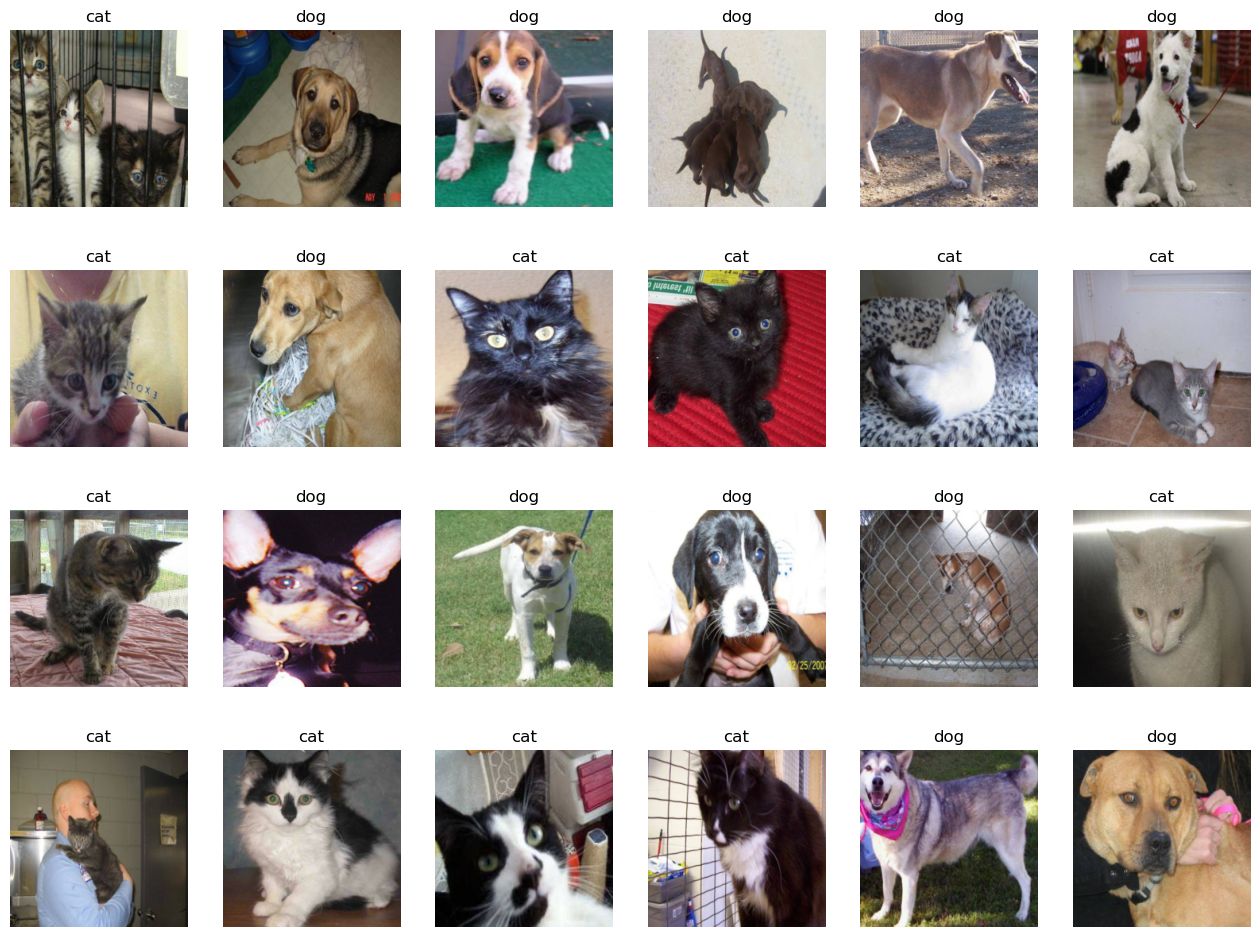

In [120]:
samples, labels = iter(train_loader).__next__()
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)


In [121]:
model = torchvision.models.resnet50(pretrained=True)

In [122]:
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 1024),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.Dropout(0.1),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

model.cuda()
summary(model, input_size=(3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):
    model.train()
    
    train_loss = 0
    train_acc = 0
    train_correct = 0
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        start = time.time()
        for train_x, train_y in train_loader:
            model.train()
            train_x, train_y = train_x.to(device), train_y.to(device).float()
            optimizer.zero_grad()
            pred = model(train_x)
            loss = criterion(pred, train_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            train_correct += y_pred.eq(train_y.cpu()).int().sum()
        
        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0
        for valid_x, valid_y in valid_loader:
            with torch.no_grad():
                model.eval()
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).float()
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            valid_correct += y_pred.eq(valid_y.cpu()).int().sum()
        
        train_acc = train_correct/len(train_loader.dataset)
        valid_acc = valid_correct/len(valid_loader.dataset)
        
        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')
        
        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)
        
        train_loss = 0
        train_acc = 0
        train_correct = 0
    
    plt.plot(train_losses, label='loss')
    plt.plot(train_accuracies, label='accuracy')
    plt.legend()
    plt.title('train loss and accuracy')
    plt.show()
    
    plt.plot(valid_losses, label='loss')
    plt.plot(valid_accuracies, label='accuracy')
    plt.legend()
    plt.title('valid loss and accuracy')
    plt.show()

def eval(model, criterion, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        losses = 0
        for test_x, test_y in test_loader:
            test_x, test_y = test_x.to(device), test_y.to(device).float()
            pred = model(test_x)
            loss = criterion(pred, test_y)
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            
            losses += loss.item()
            correct += y_pred.eq(test_y.cpu()).int().sum()
    print(f'eval loss: {losses/len(test_loader):.4f}, eval acc: {correct/len(test_loader.dataset)*100:.3f}%')


In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
 
fit(model, criterion, optimizer, 10, train_loader, valid_loader)
eval(model, criterion, test_loader)
